In [1]:
%load_ext autoreload
%autoreload 2
import sys
import numpy as np
import PIL.Image
import matplotlib.pyplot as plt
from os.path import join as oj
import pandas as pd
import pickle as pkl
import sklearn.model_selection
import models
import util
import os
import config
import viz
import scipy.stats
from tqdm import tqdm
import figs
import matplotlib.image as mpimg
import seaborn as sns

# look at celeba-hq

In [19]:
DIR_ORIG = '../data/celeba-hq/ims/'
DIRS_GEN = '../data_processed/celeba-hq/'
regs = [0, 0.1, 1, 10000]
IM_NUMS = np.arange(20, 30)

In [ ]:
R, C = len(IM_NUMS), 1 + len(regs)
plt.figure(dpi=120, figsize=(C*2.5, R*2.5))
for r, IM_NUM in enumerate(IM_NUMS):
    ims = []
    latents = []
    im_orig = mpimg.imread(oj(DIR_ORIG, f'{IM_NUM:05}.jpg'))
    for reg in regs:
        folder = f'generated_images_{reg}'
        im_fname = oj(DIRS_GEN, folder, f'{IM_NUM:05}.png')
        ims.append(mpimg.imread(im_fname))
        latents.append(np.load(oj(DIRS_GEN, folder, f'{IM_NUM:05}.npy')))
        # print(np.mean(np.abs(np.corrcoef(latents[-1]))))

    
    plt.subplot(R, C, C * r + 1)
    util.imshow(im_orig)
    if r == 0:
        plt.title('orig', fontsize=9)

    for i in range(len(regs)):
        plt.subplot(R, C, C * r + 2 + i)
        util.imshow(ims[i])
        if r == 0:
            plt.title(f'reg={regs[i]:.2e}', fontsize=9)
    latents = np.array(latents)
plt.tight_layout()

## quantitative eval

In [2]:
# number of generations done for different reg params
gen_dir = '../data_processed/celeba-hq/'
for d in os.listdir(gen_dir):
    if 'gen' in d:
        print(d, len(os.listdir(oj(gen_dir, d))) / 2)
# !python process_latents.py

generated_images_10000 100.5
generated_images_10 62.0
generated_images_1 476.5
generated_images_0.1 1438.0
generated_images 323.5
generated_images_0 321.5
generated_images_0.01 354.0


In [ ]:
from process_latents import attr_map, ks
import data


df = pd.read_pickle('processed/09_df_99.pkl')
df = df[[k for k in df.keys() if not 'lab' in k]] # add in new labs
labs, labs_full = data.load_labs()
labs = labs[:df.shape[0]]

# print(labs.head())
for k in labs.keys():
    df[k] = labs[k].values

In [ ]:
labs_full.keys()

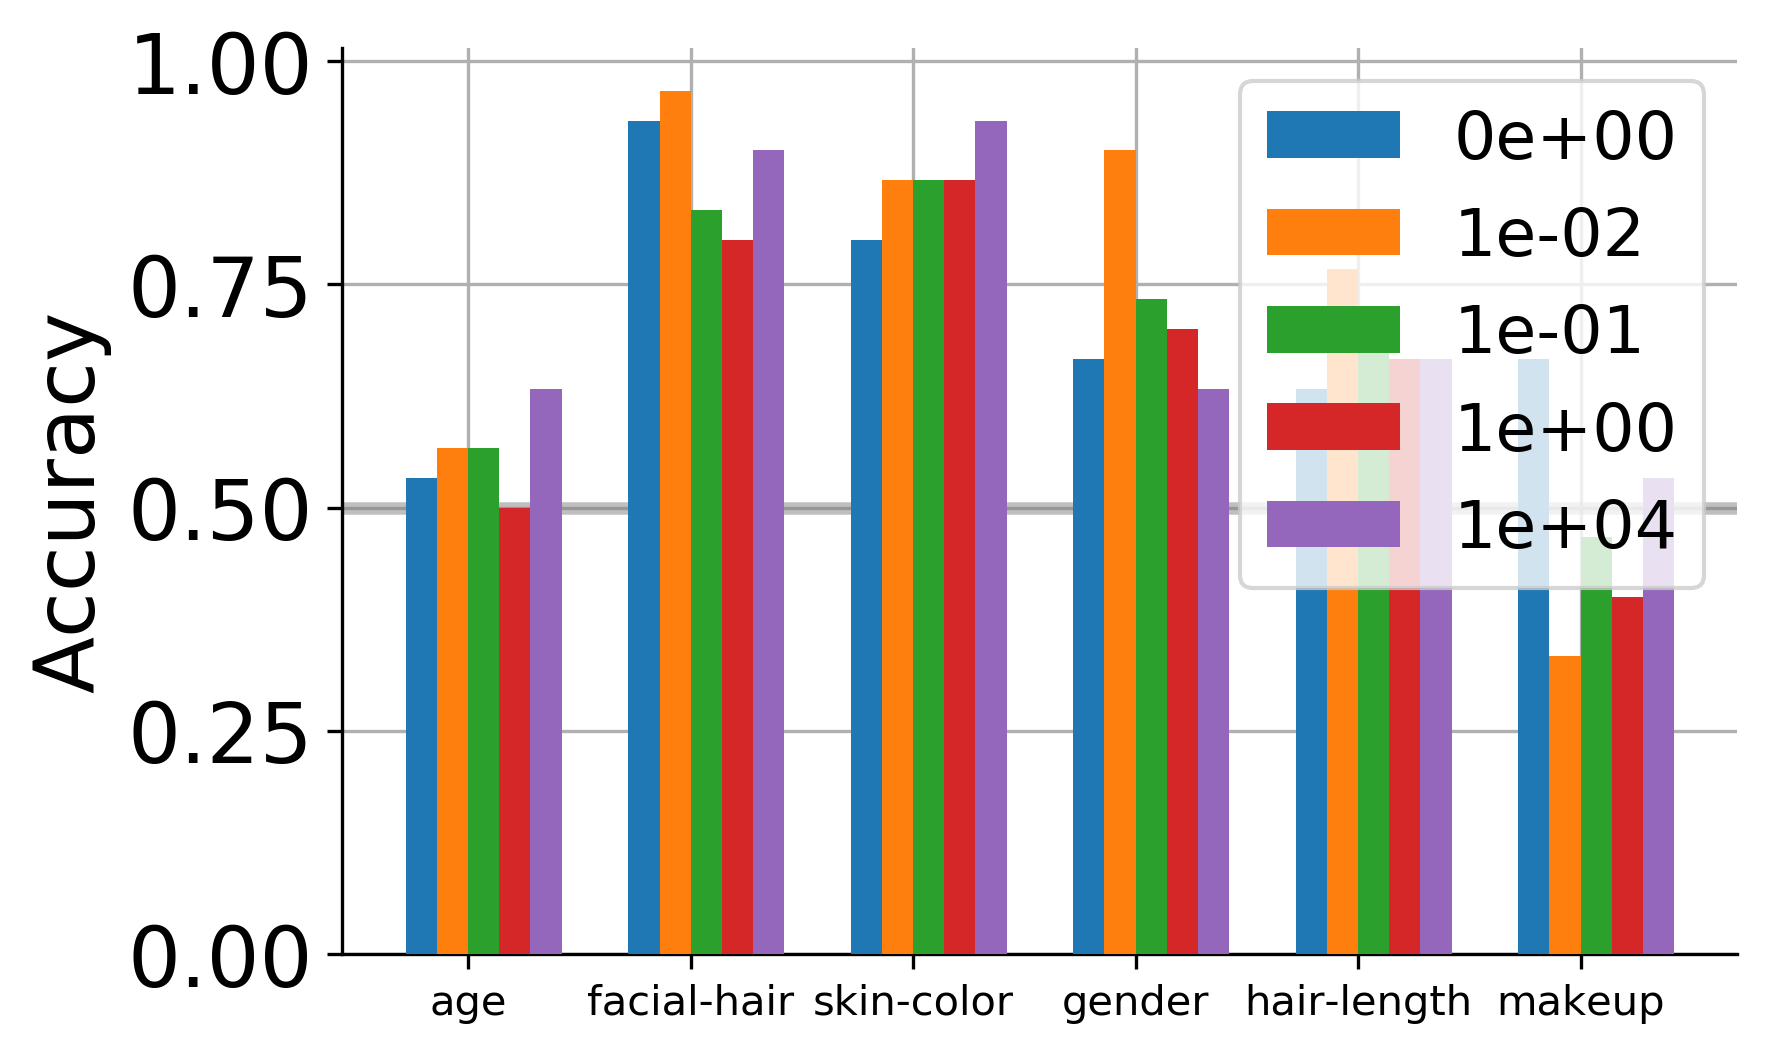

In [8]:
reg_params = df.reg_param.unique()
accs = np.zeros((len(reg_params), len(ks)))
mean_diffs = np.zeros((len(reg_params), len(ks)))
for i, k in enumerate(ks):
    predk = f'pred_{k}'
    # labk = f'lab_{k}'
    labk = f'{attr_map[k]}'
    for j, reg_param in enumerate(reg_params):
#     sns.lmplot(predk, labk, df, hue='reg_param')
        d = df[df.reg_param == reg_param]
#         accs[j, i] = np.mean((d[predk] > 0) == (d[labk] > 0))
#         mean_diffs[j, i] = np.mean(d[predk][d[labk] == 1]) - np.mean(d[predk][d[labk] == -1])
        
        accs[j, i] = np.mean((d[predk] > 0) == (d[labk] > 0))
        mean_diffs[j, i] = np.mean(d[predk][d[labk] == 1]) - np.mean(d[predk][d[labk] == 0])

        
def plot_bars(vals, ylab='Accuracy'):
    fig, ax = plt.subplots(dpi=300)
    ind = np.arange(len(ks)) # the x locations for the groups
    ps = []
    if ylab == 'Accuracy':
        plt.axhline(0.5, color='gray', alpha=0.5)
    ax.grid(zorder=0)
    for i in range(len(reg_params)):
        width = 0.14
        val = vals[i, :].flatten()
        ps.append(ax.bar(ind + width * i, val, width, zorder=3))
    plt.xticks(ind + width * 1.5, [attr_map[a] for a in ks], fontsize=10)
    
    plt.ylabel(ylab)
    ax.legend(ps, [f'{reg:.0e}' for reg in reg_params])
    plt.show()
    
# plot_bars(mean_diffs, 'Difference in means')
plot_bars(accs, 'Accuracy')

## misc plots

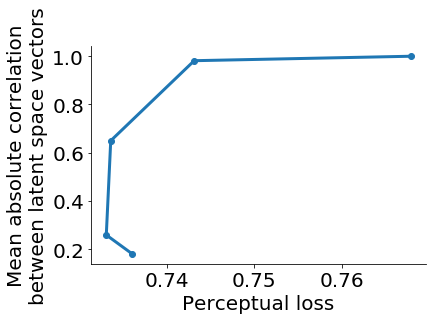

In [9]:
# plot means
means = df.groupby('reg_param').mean().reset_index()
plt.plot(means['perceptual_loss'], means['mean_abs_corr'], 'o-')
plt.xlabel('Perceptual loss')
plt.ylabel('Mean absolute correlation\nbetween latent space vectors')
plt.show()

In [ ]:
R, C = 2, 3
for i, k in enumerate(ks):
    predk = f'pred_{k}'
    labk = f'lab_{k}'
    sns.lmplot(predk, labk, df, hue='reg_param')
    plt.show()

In [ ]:
# plt.plot(df['perceptual_loss'], df['mean_abs_corr'], '.')
# d = df[df['im_num'] == 2]
d = df
sns.lmplot('perceptual_loss', 'mean_abs_corr', d, hue='reg_param')
plt.show()

## face id

In [17]:
import face_recognition

In [20]:
IM_NUMS = np.arange(1, 50)
regs = [0, 0.01, 0.1, 1, 10000]

dists = {
    reg: [] for reg in regs
}

for r, IM_NUM in tqdm(enumerate(IM_NUMS)):
    im_orig_fname = oj(DIR_ORIG, f'{IM_NUM:05}.jpg')
    im_orig = face_recognition.load_image_file(im_orig_fname)
    im_orig_encoding = face_recognition.face_encodings(im_orig)[0]

    for reg in regs:
        im_new_fname = oj(DIRS_GEN, f'generated_images_{reg}/{IM_NUM:05}.png')
        im_new = face_recognition.load_image_file(im_new_fname)
        im_new_encoding = face_recognition.face_encodings(im_new)[0]
        # results = face_recognition.compare_faces([im_orig_encoding], im_new_encoding)
        dists[reg].append(face_recognition.face_distance([im_orig_encoding], im_new_encoding)[0])
pd.DataFrame.from_dict(dists).to_csv('processed/09_dists_50.csv')

49it [04:32,  5.55s/it]


In [21]:
df = pd.read_csv('processed/09_dists_50.csv')

In [22]:
df.head()

,Unnamed: 0,0.0,0.01,0.1,1.0,10000.0
0,0,0.282189,0.242982,0.198791,0.506905,0.686844
1,1,0.356663,0.346008,0.339731,0.599027,0.579229
2,2,0.305113,0.306335,0.291769,0.481049,0.606477
3,3,0.320927,0.352912,0.333150,0.481626,0.780579
4,4,0.400456,0.277758,0.272367,0.538123,0.663851


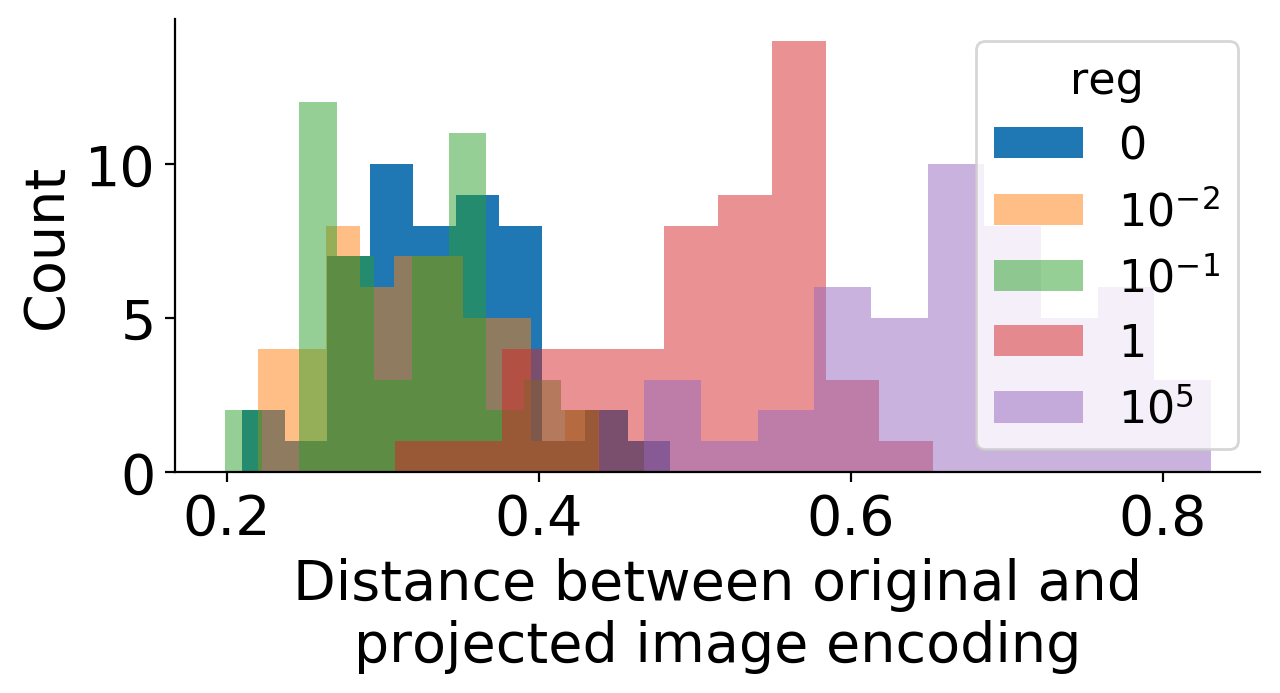

In [23]:
plt.figure(figsize=(7, 3), dpi=200)
plt.hist(df['0.0'], label='0')
plt.hist(df['0.01'], alpha=0.5, label='$10^{-2}$')
plt.hist(df['0.1'], alpha=0.5, label='$10^{-1}$')
plt.hist(df['1.0'], alpha=0.5, label='$1$')
plt.hist(df['10000.0'], alpha=0.5, label='$10^{5}$')
plt.legend(title='reg')
plt.xlabel('Distance between original and\nprojected image encoding')
plt.ylabel('Count')
plt.show()

In [ ]:
df

## look at ims

In [153]:
# look at ims
ims = []
for IM_NUM in np.arange(1, 91):
    
    ims.append(mpimg.imread(oj(DIR_ORIG, f'{IM_NUM:05}.jpg')))

images = np.array(ims)
images = images.reshape(9, 10, *images.shape[1:])

if type(images) == list:
    images = np.array(images)
N_IMS = images.shape[0]
R = images.shape[0]
C = images.shape[1]
i = 0
plt.figure(figsize=(C * 3, R * 3))
for r in range(R):
    for c in range(C):
        plt.subplot(R, C, i + 1)
        util.imshow(images[r, c])
        plt.title(str(df['gender'].values[i]))

        i += 1

plt.subplot(R, C, N_IMS // 2 + 1)
plt.tight_layout()

# Look at stylegan-generated images

In [2]:
DIR_ORIG = '../data/annotation-dataset-stylegan2/images'
DIRS_STYLEGAN = '../data_processed/stylegan2'

In [3]:
regs = [0, 0.1, 1, 10000]
IM_NUMS = [0, 1, 10]

In [ ]:
plt.figure(dpi=300)
R, C = len(IM_NUMS), 1 + len(regs)
for r, IM_NUM in enumerate(IM_NUMS):
    ims = []
    latents = []
    im_orig = mpimg.imread(oj(DIR_ORIG, f'{IM_NUM}.jpg'))
    for reg in regs:
        folder = f'generated_images_{reg}'
        im_fname = oj(DIRS_STYLEGAN, folder, f'{IM_NUM}.png')
        ims.append(mpimg.imread(im_fname))
        latents.append(np.load(oj(DIRS_STYLEGAN, folder, f'{IM_NUM}.npy')))
        print(np.mean(np.abs(np.corrcoef(latents[-1]))))

    
    plt.subplot(R, C, C * r + 1)
    util.imshow(im_orig)

    for i in range(len(regs)):
        plt.subplot(R, C, C * r + 2 + i)
        util.imshow(ims[i])

# celeba (not hq)

In [5]:
DIR_ORIG_CELEBA = '../data/CelebA/Img/img_align_celeba'
DIR_SQUARE_CELEBA = '../data/CelebA/Img/img_square_celeba'

**need to first preprocess celeba to be square before running the pipeline**

In [ ]:
for fname in tqdm(sorted(os.listdir(DIR_ORIG_CELEBA))):
    if '.jpg' in fname:
        im = mpimg.imread(oj(DIR_ORIG_CELEBA, fname))
        if not im.shape[0] == im.shape[1]:
            im = im[20:-20]
        plt.imsave(oj(DIR_SQUARE_CELEBA, fname), im)